In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import v2 as T
from torchvision.models import resnet34, vgg16
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from IPython.display import clear_output

### Загрузка датасета

In [5]:
transformer = T.Compose([
    T.Resize((192, 192)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

In [10]:
caltech101 = datasets.Caltech101(
    root='data/caltech101/',
    target_type='category',
    transform=transformer,
    download=True
)

Using downloaded and verified file: data/caltech101/caltech101\101_ObjectCategories.tar.gz
Extracting data/caltech101/caltech101\101_ObjectCategories.tar.gz to data/caltech101/caltech101


14028800it [00:01, 11465064.90it/s]


Extracting data/caltech101/caltech101\Annotations.tar to data/caltech101/caltech101


In [11]:
caltech101.categories

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [12]:
sub_categories = []
airplanes = []
for image in caltech101:
    if image[0].shape[0] == 3:
        if image[1] in [12, 13, 19, 2, 3]:
            sub_categories.append(image[0])
        if image[1] == 5:
            airplanes.append(image[0])
len(sub_categories), len(airplanes)

(1347, 800)

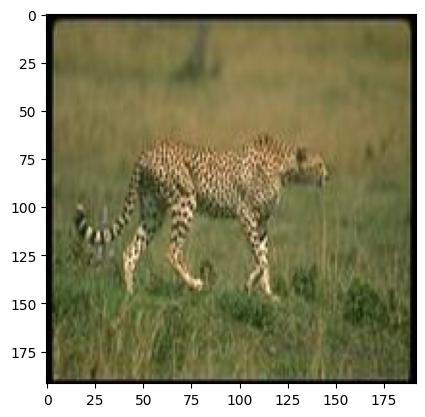

In [13]:
image = x = np.einsum('cwh->whc', sub_categories[0])
plt.imshow(image)

In [14]:
airplanes[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

### Строим модель

In [15]:
def train(model, data_loader, optimizer, loss_fn, device):
    model.to(device)
    model.train()

    train_loss = []
    for x in data_loader:
        x = x.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = loss_fn(out, x)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

@torch.no_grad()
def evaluate(model, data_loader, loss_fn, device):
    model.to(device)
    model.eval()
    
    evalute_loss = []
    for x in data_loader:
        x = x.to(device)
        out = model(x)
        loss = loss_fn(out, x)
        evalute_loss.append(loss.item())
    
    return np.mean(evalute_loss)


In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, is_last=False):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = kernel_size,
        self.padding = padding,
        self.stride = stride
        self.is_last = is_last
        self.conv = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size[0],
            padding=self.padding,
            stride=self.stride
        )
        self.normalization = nn.BatchNorm2d(num_features=self.out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        if not self.is_last:
            x = self.normalization(x)
            x = self.act(x)
        return x

class EncodeBlock(ConvBlock):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, is_last=False):
        super().__init__(in_channels, out_channels, kernel_size, padding, stride, is_last)
        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2))
    
    def forward(self, x):
        x = super().forward(x)
        x = self.max_pooling(x)
        return x

class DecodeBlock(ConvBlock):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, scale_factor=2, is_last=False):
        super().__init__(in_channels, out_channels, kernel_size, padding, stride, is_last)
        self.scale_factor = scale_factor

    def forward(self, x):
        x = nn.functional.interpolate(
            x,
            scale_factor=self.scale_factor,
            mode='bilinear',
            recompute_scale_factor=False
        )
        x = super().forward(x)
        return x


class AutoencoderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_channels = 6
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(
            ConvBlock(3, self.base_channels),
            EncodeBlock(in_channels=self.base_channels, out_channels=self.base_channels),
            ConvBlock(self.base_channels, self.base_channels * 2),
            EncodeBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels * 2),
            ConvBlock(self.base_channels* 2, self.base_channels * 4),
            EncodeBlock(in_channels=self.base_channels * 4, out_channels=self.base_channels * 4, is_last=True),
        )
        self.decoder = nn.Sequential(
            DecodeBlock(in_channels=self.base_channels * 4, out_channels=self.base_channels * 2),
            DecodeBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels),
            DecodeBlock(in_channels=self.base_channels, out_channels=3, is_last=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.sigmoid(x)
        return x

    @torch.no_grad()
    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x


In [17]:
dataset = torch.stack(sub_categories)

In [18]:
model = AutoencoderModel()
train_data, test_data = random_split(dataset, (0.8, 0.2))
train_data_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=True)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device('cuda')
model.to(device)
num_epoch = 10

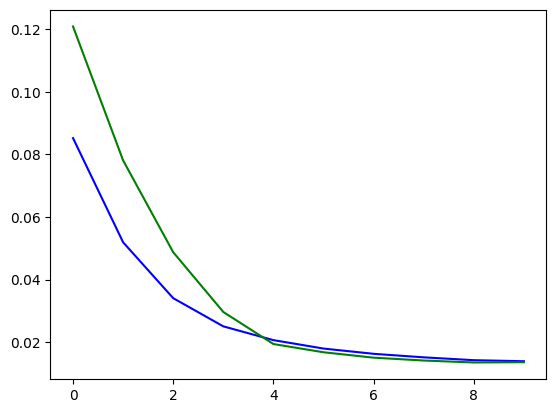

In [294]:
train_loss, test_loss = [], []

for epoch in range(1, num_epoch + 1):
    train_out = train(model, train_data_loader, optimizer, loss_fn, device)
    test_out = evaluate(model, test_data_loader, loss_fn, device)
    train_loss.append(train_out)
    test_loss.append(test_out)

    clear_output(wait=True)
    plt.plot(train_loss, color='blue')
    plt.plot(test_loss, color='green')
    plt.show()

In [19]:
def plot_nearest_neighbors(image_data, neighbors_ids, neighbors_dist, similarity_probas):
    _, ax = plt.subplots(1, 5, figsize=(14, 3))
    for idx, item in enumerate(neighbors_ids):
        image = np.einsum('cwh->whc', image_data[item])    
        ax[idx].imshow(image)
        ax[idx].set_title('proba:' + str(int(similarity_probas[idx] * 100)) + '% dist:' + str(round(neighbors_dist[idx], 2)))
        
    plt.suptitle('nearest neighbors')
    plt.show()


def plot_nearest_neighbors_tsne(tsne_df, neighbors_ids):
    _, ax = plt.subplots(figsize=(14, 6))
    ax.set_title('tsne nearest neighbors')
    ax.scatter(tsne_df.x, tsne_df.y, alpha=.1)
    ax.scatter(tsne_df.iloc[neighbors_ids].x, tsne_df.iloc[neighbors_ids].y, alpha=.5, color='green')


In [20]:
def get_embeddings_proba(target_emb, neighbors_embs):
    probas = []
    for neighbor in neighbors_embs:
        proba = np.absolute(np.dot(target_emb, neighbor) / np.linalg.norm(target_emb) / np.linalg.norm(neighbor))
        probas.append(proba)
    return probas

In [21]:
@torch.inference_mode()
def any_model_predict(model, x, device, is_encoder=False):
    model.to(device)
    result = []
    for x in DataLoader(x, batch_size=100):
        x = x.to(device)
        if is_encoder:
            out = model.encode(x)
        else:
            out = model(x)
        result.extend(out.cpu())

    return torch.stack(result)

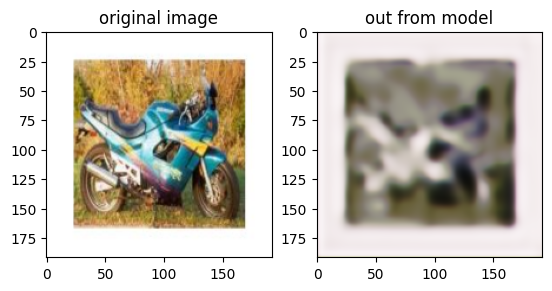

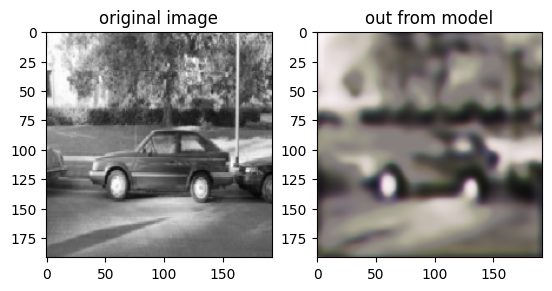

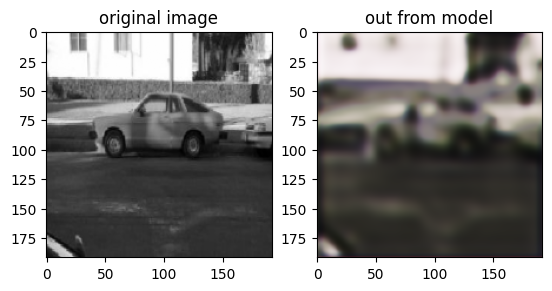

In [298]:
model.cpu()
for image in random.sample(sub_categories, 3):
    image = image.reshape(-1, *image.shape)
    out = model(image)
    embedding = model.encode(image)
    
    image = np.einsum('cwh->whc', image[0].detach().numpy())
    out = np.einsum('cwh->whc', out[0].detach().numpy())

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(out)
    ax[0].set_title('original image')
    ax[1].set_title('out from model')

In [299]:
train_data = [x for x in train_data]

In [300]:
train_data_embeddings = any_model_predict(model, train_data, device, is_encoder=True)

In [301]:
nearest_clf = NearestNeighbors(n_neighbors=5)
nearest_clf.fit(train_data_embeddings)

NearestNeighbors()

In [302]:
tsne = TSNE()
comp = tsne.fit_transform(train_data_embeddings)

df = pd.DataFrame()
df['x'] = comp[:, 0]
df['y'] = comp[:, 1]

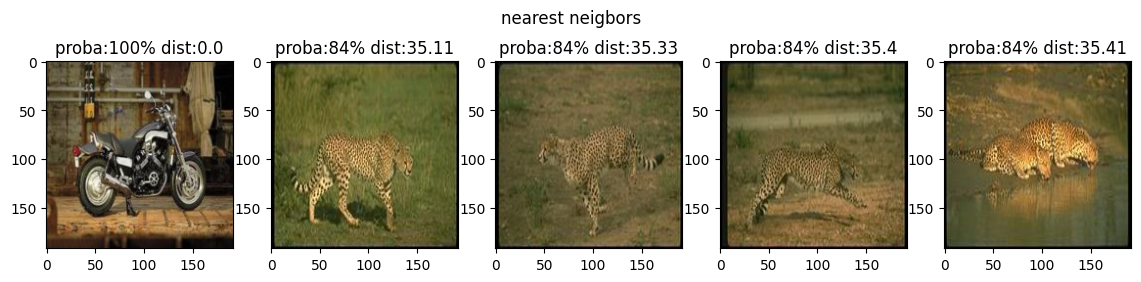

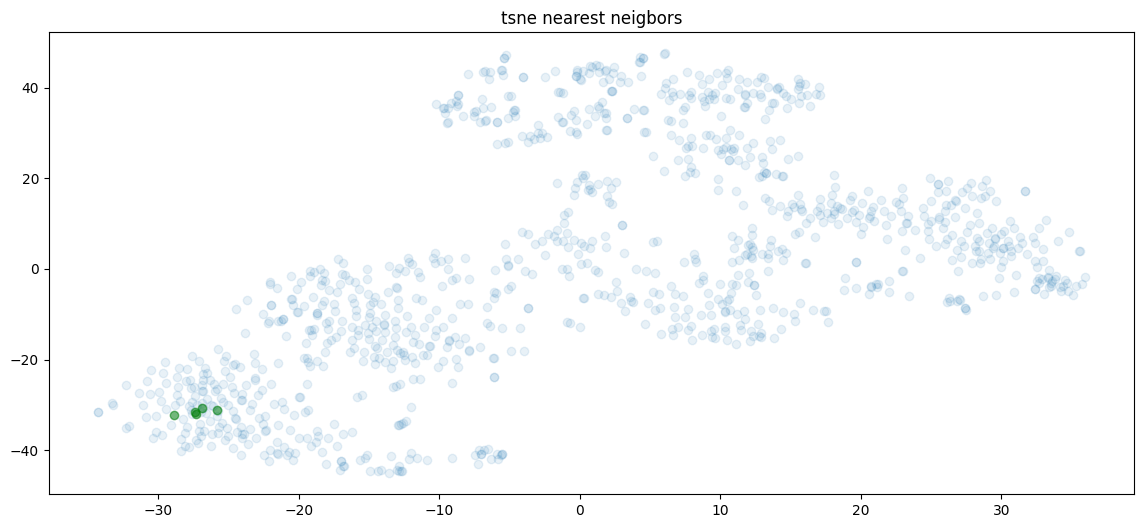

In [303]:
neighbors = nearest_clf.kneighbors(train_data_embeddings[42].reshape(1, -1), 5)

probas = get_embeddings_proba(
    target_emb=train_data_embeddings[42],
    neighbors_embs=train_data_embeddings[neighbors[1][0]]
)

plot_nearest_neighbors(
    train_data,
    neighbors[1][0],
    neighbors[0][0],
    probas
)
plot_nearest_neighbors_tsne(
    df,
    neighbors[1][0]
)

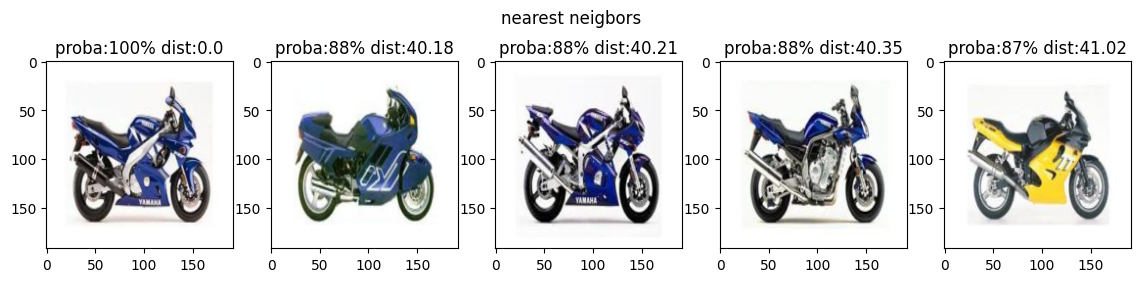

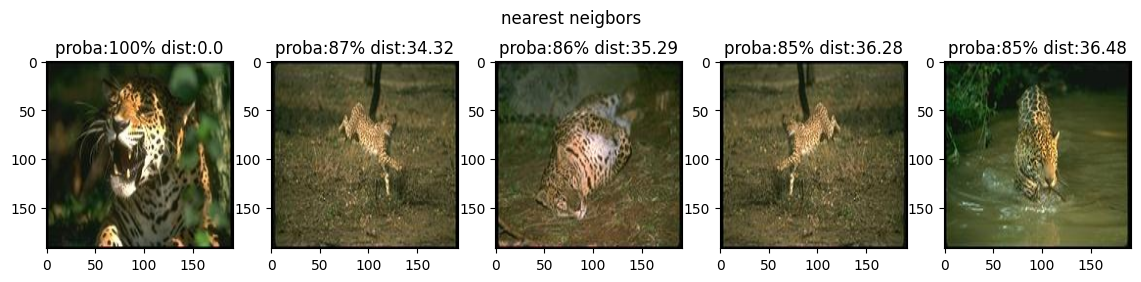

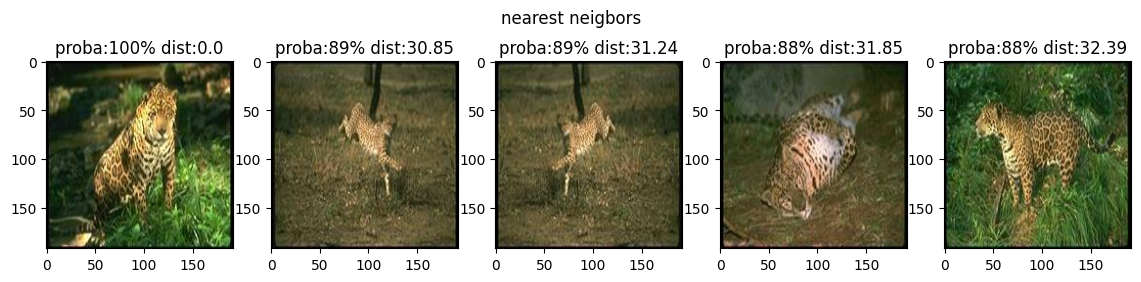

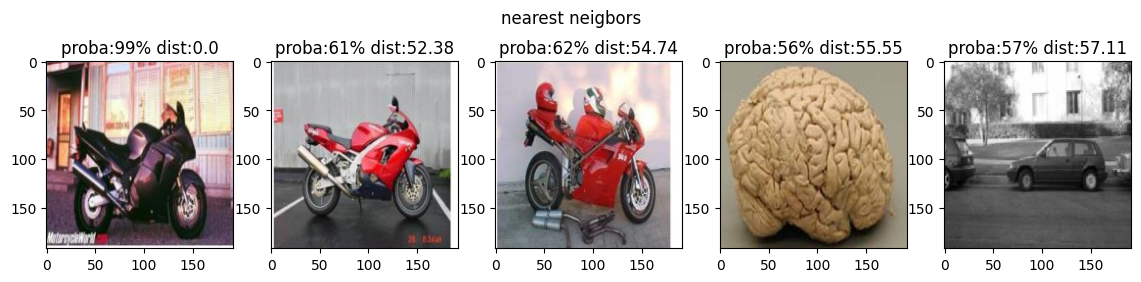

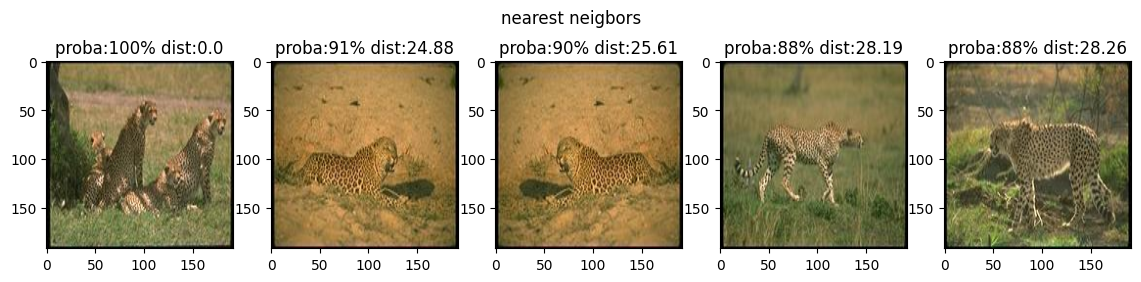

In [304]:
for i in np.random.randint(0, 1078, 5):
    neighbors = nearest_clf.kneighbors(train_data_embeddings[i].reshape(1, -1), 5)

    probas = get_embeddings_proba(
        target_emb=train_data_embeddings[i],
        neighbors_embs=train_data_embeddings[neighbors[1][0]]
    )

    plot_nearest_neighbors(
        train_data,
        neighbors[1][0],
        neighbors[0][0],
        probas
    )

In [305]:
air_embeddings = any_model_predict(model, torch.stack(airplanes), device, is_encoder=True)

nearest_clf_air = NearestNeighbors(n_neighbors=5)
nearest_clf_air.fit(air_embeddings)

NearestNeighbors()

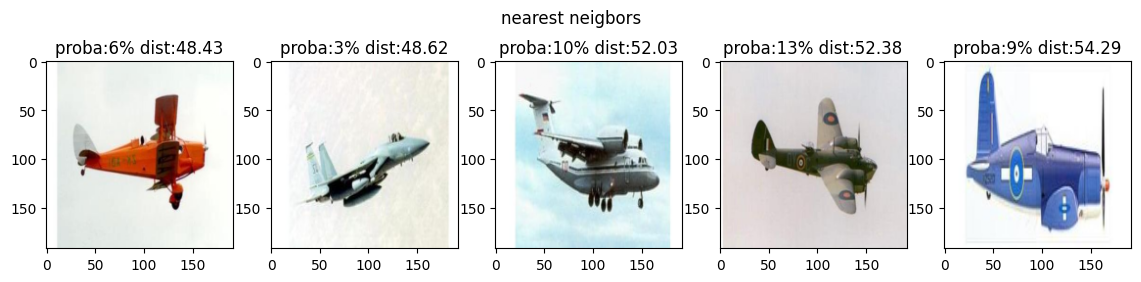

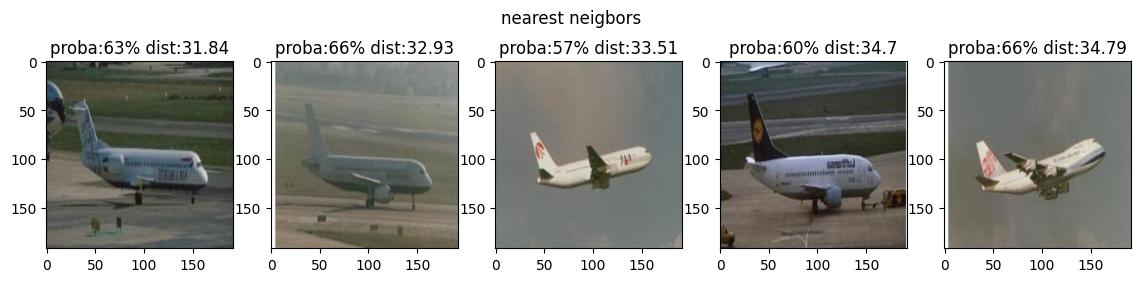

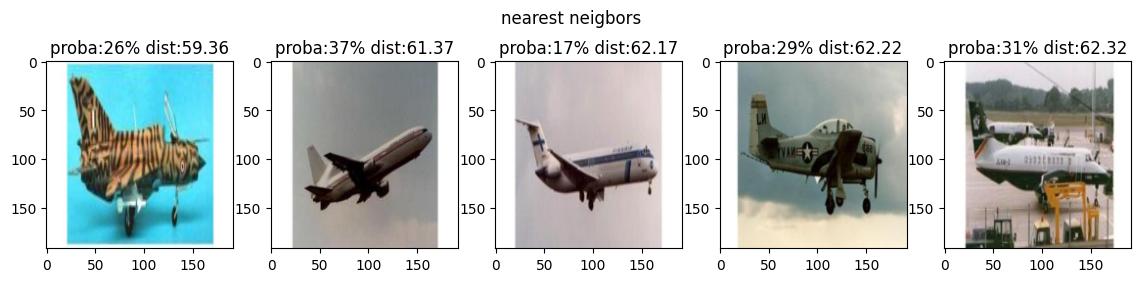

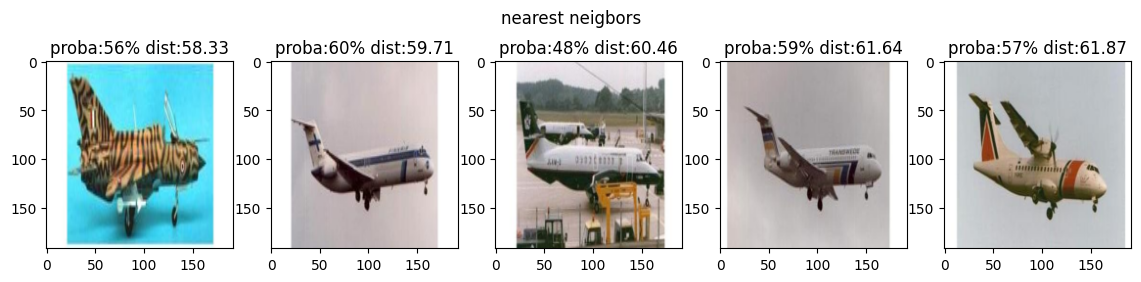

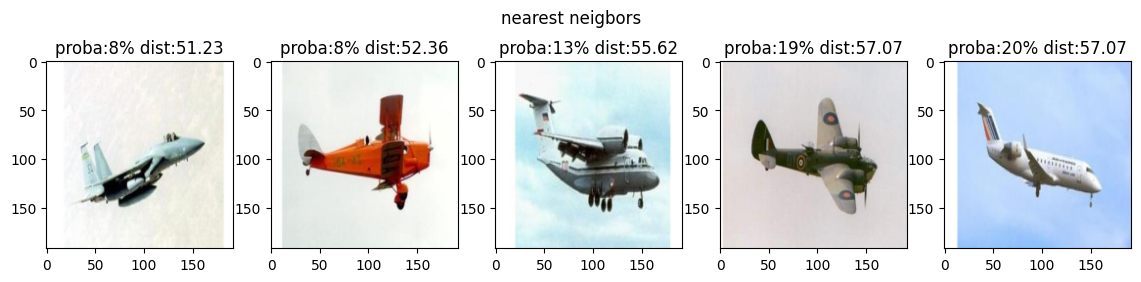

In [306]:
for i in np.random.randint(0, 800, 5):
    neighbors = nearest_clf_air.kneighbors(train_data_embeddings[i].reshape(1, -1), 5)

    probas = get_embeddings_proba(
        target_emb=air_embeddings[i],
        neighbors_embs=air_embeddings[neighbors[1][0]]
    )

    plot_nearest_neighbors(
        airplanes,
        neighbors[1][0],
        neighbors[0][0],
        probas
    )

In [307]:
np.random.seed(0)
air_probas = []
all_probas = []

for i in np.random.randint(0, 800, 100):
    neighbors_air = nearest_clf_air.kneighbors(air_embeddings[i].reshape(1, -1), 6)[1][0][1:]
    neighbors_all = nearest_clf_air.kneighbors(train_data_embeddings[i].reshape(1, -1), 5)[1][0]

    probas_air = get_embeddings_proba(target_emb=air_embeddings[i], neighbors_embs=air_embeddings[neighbors_air])
    probas_all = get_embeddings_proba(target_emb=air_embeddings[i], neighbors_embs=train_data_embeddings[neighbors_all])

    air_probas.extend(probas_air)
    all_probas.extend(probas_all)

print(f'Average similarity prediction for 100 random airplanes between airplanes: {int(np.mean(air_probas) * 100)}%')
print(f'Average similarity prediction for 100 random airplanes between objects: {int(np.mean(all_probas) * 100)}%')


Average similarity prediction for 100 random airplanes between airplanes: 78%
Average similarity prediction for 100 random airplanes between objects: 35%


In [308]:
model

AutoencoderModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid): Sigmoid()
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1,))
      (normalization): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): EncodeBlock(
      (conv): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1,))
      (normalization): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1,))
      (normalization): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (3): EncodeBlock(
      (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1,))
      

In [309]:
optimizer = Adam([
    {'params': model.encoder[2].parameters(), 'lr': 1e-5},
    {'params': model.encoder[3].parameters(), 'lr': 1e-5},
    {'params': model.encoder[4].parameters(), 'lr': 1e-4},
    {'params': model.encoder[5].parameters(), 'lr': 1e-4},
    {'params': model.decoder[0].parameters(), 'lr': 1e-4},
    {'params': model.decoder[1].parameters(), 'lr': 1e-5}
])

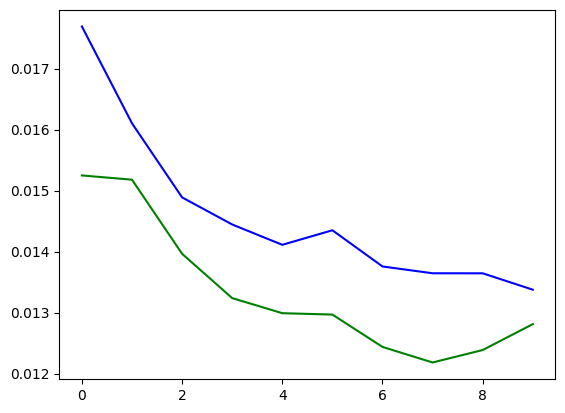

In [310]:
model.cpu()
train_loss, test_loss = [], []

air_train_data, air_test_data = random_split(airplanes, (0.8, 0.2))
air_train_data_loader = DataLoader(dataset=air_train_data, batch_size=30, shuffle=True)
air_test_data_loader = DataLoader(dataset=air_test_data, batch_size=30, shuffle=True)

for epoch in range(1, 11):
    train_out = train(model, air_train_data_loader, optimizer, loss_fn, device)
    train_loss.append(train_out)
    test_out = evaluate(model, air_test_data_loader, loss_fn, device)
    test_loss.append(test_out)

    clear_output(wait=True)
    plt.plot(train_loss, color='blue')
    plt.plot(test_loss, color='green')
    plt.show()

In [311]:
model.cpu()
air_embeddings_fine_tune = model.encode(torch.stack(airplanes))
train_data_embeddings_fine_tune = model.encode(torch.stack(train_data))

In [312]:
nearest_clf_air.fit(air_embeddings_fine_tune)

NearestNeighbors()

In [313]:
air_probas_fine_tune = []
all_probas_fine_tune = []

for i in np.random.randint(0, 800, 100):
    neighbors_air = nearest_clf_air.kneighbors(air_embeddings_fine_tune[i].reshape(1, -1), 6)[1][0][1:]
    neighbors_all = nearest_clf_air.kneighbors(train_data_embeddings_fine_tune[i].reshape(1, -1), 5)[1][0]

    probas_air = get_embeddings_proba(target_emb=air_embeddings_fine_tune[i], neighbors_embs=air_embeddings_fine_tune[neighbors_air])
    probas_all = get_embeddings_proba(target_emb=air_embeddings_fine_tune[i], neighbors_embs=train_data_embeddings_fine_tune[neighbors_all])

    air_probas_fine_tune.extend(probas_air)
    all_probas_fine_tune.extend(probas_all)

print(f'Average similarity prediction for 100 random airplanes between airplanes after fine tuning: {int(np.mean(air_probas_fine_tune) * 100)}%')
print(f'Average similarity prediction for 100 random airplanes between objects after fine tuning: {int(np.mean(all_probas_fine_tune) * 100)}%')

Average similarity prediction for 100 random airplanes between airplanes after fine tuning: 75%
Average similarity prediction for 100 random airplanes between objects after fine tuning: 35%


### ResNet

In [314]:
transformer = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

caltech101 = datasets.Caltech101(
    root='data/caltech101/',
    target_type='category',
    transform=transformer,
    download=True
)

airplanes_256x256 = []
for image in caltech101:
    if image[0].shape[0] == 3:
        if image[1] == 5:
            airplanes_256x256.append(image[0])
len(airplanes_256x256)

Files already downloaded and verified


800

In [315]:
resnet_model = resnet34(weights='DEFAULT')
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [316]:
resnet_model.fc = nn.Flatten()

In [317]:
len(airplanes_256x256), airplanes_256x256[0].shape

(800, torch.Size([3, 256, 256]))

In [318]:
resnet_emb = any_model_predict(resnet_model, torch.stack(airplanes_256x256), device)

In [319]:
nearest_clf_resnet = NearestNeighbors(n_neighbors=5)
nearest_clf_resnet.fit(resnet_emb)

NearestNeighbors()

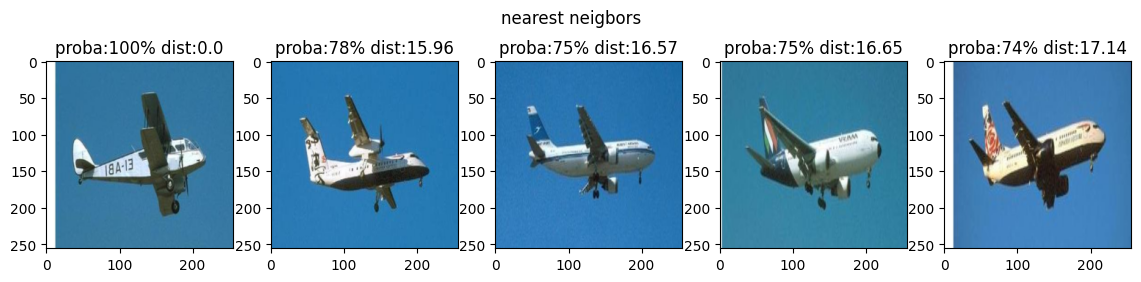

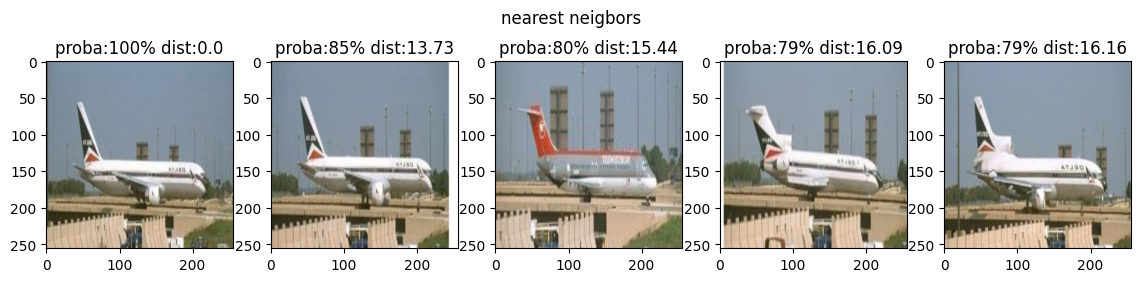

In [320]:
for i in np.random.randint(0, 800, 2):
    neighbors = nearest_clf_resnet.kneighbors(resnet_emb[i].reshape(1, -1), 5)

    probas = get_embeddings_proba(
        target_emb=resnet_emb[i],
        neighbors_embs=resnet_emb[neighbors[1][0]]
    )

    plot_nearest_neighbors(
        airplanes_256x256,
        neighbors[1][0],
        neighbors[0][0],
        probas
    )

In [321]:
resnet_probas = []
all_resnet_probas = []

all_emb = any_model_predict(resnet_model, torch.stack(sub_categories), device)

for i in np.random.randint(0, 800, 100):
    neighbors_air = nearest_clf_resnet.kneighbors(resnet_emb[i].reshape(1, -1), 6)[1][0][1:]
    neighbors_all = nearest_clf_resnet.kneighbors(all_emb[i].reshape(1, -1), 5)[1][0]

    probas_air = get_embeddings_proba(target_emb=resnet_emb[i], neighbors_embs=resnet_emb[neighbors_air])
    probas_all = get_embeddings_proba(target_emb=resnet_emb[i], neighbors_embs=all_emb[neighbors_all])

    resnet_probas.extend(probas_air)
    all_resnet_probas.extend(probas_all)

print(f'Average similarity prediction for 100 random airplanes between airplanes resnet model: {int(np.mean(resnet_probas) * 100)}%')
print(f'Average similarity prediction for 100 random airplanes between objects resnet model: {int(np.mean(all_resnet_probas) * 100)}%')

Average similarity prediction for 100 random airplanes between airplanes resnet model: 77%
Average similarity prediction for 100 random airplanes between objects resnet model: 62%


### VGG

In [322]:
vgg_model = vgg16(weights='DEFAULT')
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [323]:
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-3])
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [324]:
vgg_emb = any_model_predict(vgg_model, torch.stack(airplanes_256x256), device)

nearest_clf_vgg = NearestNeighbors(n_neighbors=5)
nearest_clf_vgg.fit(vgg_emb)

NearestNeighbors()

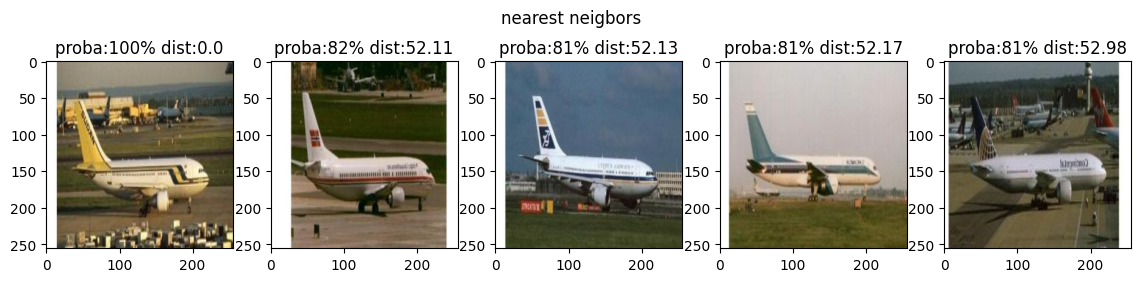

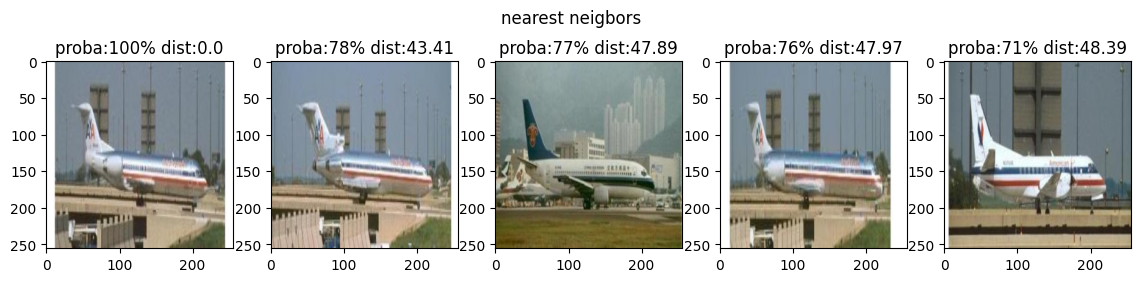

In [325]:
for i in np.random.randint(0, 800, 2):
    neighbors = nearest_clf_vgg.kneighbors(vgg_emb[i].reshape(1, -1), 5)

    probas = get_embeddings_proba(
        target_emb=vgg_emb[i],
        neighbors_embs=vgg_emb[neighbors[1][0]]
    )

    plot_nearest_neighbors(
        image_data=airplanes_256x256,
        neighbors_ids=neighbors[1][0],
        neighbors_dist=neighbors[0][0],
        similarity_probas=probas
    )

In [326]:
vgg_probas = []
all_vgg_probas = []

all_emb = any_model_predict(vgg_model, torch.stack(sub_categories), device)

for i in np.random.randint(0, 800, 100):
    neighbors_air = nearest_clf_vgg.kneighbors(vgg_emb[i].reshape(1, -1), 6)[1][0][1:]
    neighbors_all = nearest_clf_vgg.kneighbors(all_emb[i].reshape(1, -1), 5)[1][0]

    probas_air = get_embeddings_proba(target_emb=vgg_emb[i], neighbors_embs=vgg_emb[neighbors_air])
    probas_all = get_embeddings_proba(target_emb=vgg_emb[i], neighbors_embs=all_emb[neighbors_all])

    vgg_probas.extend(probas_air)
    all_vgg_probas.extend(probas_all)

print(f'Average similarity prediction for 100 random airplanes between airplanes resnet model: {int(np.mean(vgg_probas) * 100)}%')
print(f'Average similarity prediction for 100 random airplanes between objects resnet model: {int(np.mean(all_vgg_probas) * 100)}%')

Average similarity prediction for 100 random airplanes between airplanes resnet model: 78%
Average similarity prediction for 100 random airplanes between objects resnet model: 35%


В основном интересует разница в схожести "самолет с самолетами" и "самолет с разными объектами"
- ResNet показывает крайне плохие результаты
- Хорошие резальтаты показывает vgg16 модель, но она очень много весит
- Автоенкодеры с дообучением показывают результаты немного хуже vgg16, можно попробовать подобрать более успешный автоенкодер

In [22]:
class FinalAutoencoderModel(AutoencoderModel):
    def __init__(self):
        super().__init__()
        self.base_channels = 8
        self.encoder = nn.Sequential(
            ConvBlock(3, self.base_channels, kernel_size=(5, 5), padding=2),
            ConvBlock(self.base_channels, self.base_channels, kernel_size=(5, 5), padding=2),
            EncodeBlock(in_channels=self.base_channels, out_channels=self.base_channels),
            ConvBlock(self.base_channels, self.base_channels * 2),
            ConvBlock(self.base_channels * 2, self.base_channels * 2),
            EncodeBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels * 2, is_last=True)
        )
        self.decoder = nn.Sequential(
            DecodeBlock(in_channels=self.base_channels * 2, out_channels=self.base_channels),
            DecodeBlock(in_channels=self.base_channels, out_channels=3, is_last=True)
        )

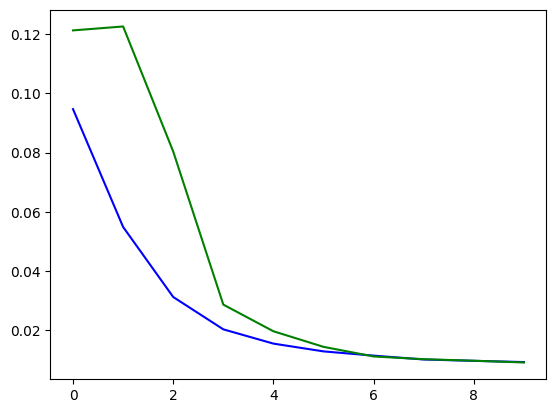

In [23]:
model = FinalAutoencoderModel()
optimizer = Adam(model.parameters(), lr=1e-3)

train_loss, test_loss = [], []

for epoch in range(1, num_epoch + 1):
    train_out = train(model, train_data_loader, optimizer, loss_fn, device)
    test_out = evaluate(model, test_data_loader, loss_fn, device)
    train_loss.append(train_out)
    test_loss.append(test_out)

    clear_output(wait=True)
    plt.plot(train_loss, color='blue')
    plt.plot(test_loss, color='green')
    plt.show()

In [24]:
air_embeddings = any_model_predict(model, torch.stack(airplanes), device, is_encoder=True)
train_data_embeddings = any_model_predict(model, train_data, device, is_encoder=True)

nearest_clf_air = NearestNeighbors(n_neighbors=5)
nearest_clf_air.fit(air_embeddings)

NearestNeighbors()

In [25]:
np.random.seed(0)
air_probas = []
all_probas = []

for i in np.random.randint(0, 800, 100):
    neighbors_air = nearest_clf_air.kneighbors(air_embeddings[i].reshape(1, -1), 6)[1][0][1:]
    neighbors_all = nearest_clf_air.kneighbors(train_data_embeddings[i].reshape(1, -1), 5)[1][0]

    probas_air = get_embeddings_proba(target_emb=air_embeddings[i], neighbors_embs=air_embeddings[neighbors_air])
    probas_all = get_embeddings_proba(target_emb=air_embeddings[i], neighbors_embs=train_data_embeddings[neighbors_all])

    air_probas.extend(probas_air)
    all_probas.extend(probas_all)

print(f'Average similarity prediction for 100 random airplanes between airplanes: {int(np.mean(air_probas) * 100)}%')
print(f'Average similarity prediction for 100 random airplanes between objects: {int(np.mean(all_probas) * 100)}%')

Average similarity prediction for 100 random airplanes between airplanes: 78%
Average similarity prediction for 100 random airplanes between objects: 38%


Обучим модель на всем датасете и сохраним

In [26]:
transformer = T.Compose([
    T.Resize((192, 192)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

caltech101 = datasets.Caltech101(
    root='data/caltech101/',
    target_type='category',
    transform=transformer,
    download=True
)

Files already downloaded and verified


In [27]:
caltech101[0][0]

tensor([[[0.2745, 0.2784, 0.2745,  ..., 0.5294, 0.5255, 0.5098],
         [0.3255, 0.3294, 0.3255,  ..., 0.5882, 0.5882, 0.5608],
         [0.4902, 0.5373, 0.5412,  ..., 0.5882, 0.5882, 0.5569],
         ...,
         [0.5098, 0.5373, 0.5373,  ..., 0.1961, 0.2039, 0.1765],
         [0.5098, 0.5373, 0.5373,  ..., 0.2000, 0.2196, 0.1882],
         [0.4549, 0.4824, 0.4824,  ..., 0.1725, 0.1922, 0.1647]],

        [[0.2627, 0.2706, 0.2745,  ..., 0.5255, 0.5216, 0.5059],
         [0.3137, 0.3255, 0.3255,  ..., 0.5843, 0.5843, 0.5569],
         [0.4784, 0.5333, 0.5451,  ..., 0.5843, 0.5843, 0.5529],
         ...,
         [0.5176, 0.5451, 0.5451,  ..., 0.2549, 0.2627, 0.2353],
         [0.5176, 0.5451, 0.5451,  ..., 0.2549, 0.2745, 0.2471],
         [0.4667, 0.4902, 0.4941,  ..., 0.2196, 0.2431, 0.2196]],

        [[0.2157, 0.2353, 0.2510,  ..., 0.5098, 0.5059, 0.4902],
         [0.2706, 0.2902, 0.3059,  ..., 0.5686, 0.5686, 0.5412],
         [0.4510, 0.5098, 0.5255,  ..., 0.5686, 0.5686, 0.

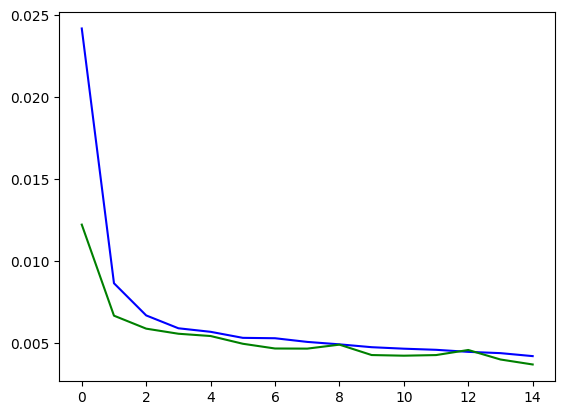

In [28]:
model = FinalAutoencoderModel()
optimizer = Adam(model.parameters(), lr=1e-3)
num_epoch = 15


train_data, test_data = random_split([x[0] for x in caltech101], (0.8, 0.2))
train_data_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=True)

train_loss, test_loss = [], []

for epoch in range(1, num_epoch + 1):
    train_out = train(model, train_data_loader, optimizer, loss_fn, device)
    test_out = evaluate(model, test_data_loader, loss_fn, device)
    train_loss.append(train_out)
    test_loss.append(test_out)

    clear_output(wait=True)
    plt.plot(train_loss, color='blue')
    plt.plot(test_loss, color='green')
    plt.show()

In [29]:
model.eval()
torch.save(model.state_dict(), 'autoencoder_dict.pt')